# Location Analysis

* Module Name: location.ipynb
* Description: perform nalysis on location data we capture from the pipeline

Copyright (C) 2025 J.Cincotta

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program. If not, see <https://www.gnu.org/licenses/>.


In [4]:
from torch.nn.functional import threshold

"""
Configuration for this notebook:
"""

filename: str = "/project/data/wod_output/2050528/final-output.csv"
historic_sample_window_size: int = 10
dwell_distance_threshold: float = 20.0
# this reflects the values in the COCOs training data
names = ["Zarafa", "Ebo", "Jimiyu", "Kito"]

## Import data 

Super quick and dirty CSV loader that parses the `( xx | zz )` coordinate strings back into a list of tuples.

The resulting data structure is:

* Sample dict with the keys representing samples.
* Every sample contains a dict with key representing individuals identifier.
* The content of the individual dict are two keys: "intersect" and "timestamp"
* "intersect" contains an array of x,z coordinates as tuples.

In [5]:
import csv
from datetime import datetime


def parse(src: str) -> list:
    return [(int(o.partition("|")[0].strip()), int(o.partition("|")[2].strip())) for o in src.replace(")","").split("(") if o]


samples: dict = {}
row_count = 0
sample_count = 0
with open(filename, "r") as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        if int(row["sample"].strip()) > sample_count:
            sample_count = int(row["sample"].strip())
        sample = samples.get(row["sample"], {})
        identity = sample.get(row["identity"], {})
        identity["intersect"] = parse(row["intersect"])
        identity["timestamp"] = datetime.strptime(row["timestamp"], '%Y-%m-%d %H:%M:%S')
        sample[row["identity"]] = identity
        samples[row["sample"]] = sample
        row_count += 1

print(f"Imported {filename} with {row_count} rows containing {sample_count} samples.")


Imported /project/data/wod_output/2050528/final-output.csv with 59623 rows containing 107342 samples.


## Identify individuals

In [6]:
identities: list = []
for sample in samples.keys():
    for individual in samples[sample].keys():
        if individual not in identities:
            identities.append(individual)

print(f"Found the following individuals: {[names[int(o) - 1] for o in identities]}")


Found the following individuals: ['Jimiyu', 'Zarafa', 'Ebo', 'Kito']


## Identify the start and end time of the sampling period

In [7]:
from datetime import datetime


times: list = []
for sample in samples.keys():
    for individual in samples[sample].keys():
        times.append(samples[sample][individual]["timestamp"])
        # print(samples[sample][individual]["timestamp"].strftime('%Y-%m-%d %H:%M:%S'))

start_time = min(times)
end_time = max(times)
sampling_time_span = end_time - start_time

print(f"Sample range: {start_time.strftime('%Y-%m-%d %H:%M:%S')} to {end_time.strftime('%Y-%m-%d %H:%M:%S')} ({sampling_time_span})")



Sample range: 2025-03-10 10:28:07 to 2025-03-16 15:33:12 (6 days, 5:05:05)


## Identify the delta of the individual from the previous sample. 

This is achieved by using centroid distance between the clusters representing the location at two samples (times).

Note that we can effectively use centroid distance and nothing more complex here since these points have been pre-processed with DBScan and outliers have been removed already.

In [8]:
import numpy as np


def centroid_distance(cluster1, cluster2):
    centroid1 = np.mean(cluster1, axis=0)
    centroid2 = np.mean(cluster2, axis=0)
    return np.linalg.norm(centroid1 - centroid2)


previous_sample_key = None
for sample_key in samples.keys():
    for identity_key in identities:
        if identity_key in samples[sample_key].keys():
            samples[sample_key][identity_key]["centroid-distance"] = 0
            if previous_sample_key in samples.keys():
                if identity_key in samples[sample_key].keys() and identity_key in samples[previous_sample_key].keys():
                    samples[sample_key][identity_key]["centroid-distance"] = float(centroid_distance(
                        np.array(samples[sample_key][identity_key]["intersect"]),
                        np.array(samples[previous_sample_key][identity_key]["intersect"])
                    ))

    previous_sample_key = sample_key

print(f"Calculated centroids for {len(samples)} samples.")


Calculated centroids for 28315 samples.


## Use thresholding to deterime the difference between dwell and locomotion

In [9]:
import numpy as np


def centroid_distance(cluster1, cluster2):
    centroid1 = np.mean(cluster1, axis=0)
    centroid2 = np.mean(cluster2, axis=0)
    return np.linalg.norm(centroid1 - centroid2)


identity_history: dict = {}
tmp_ss = historic_sample_window_size * -1

for identity_key in identities:
    identity_history[identity_key] = []

for sample_key in samples.keys():
    for identity_key in identities:
        if identity_key in samples[sample_key].keys():
            identity_history[identity_key].append(samples[sample_key][identity_key]["centroid-distance"])
            # We take the average movement of the centroid over a defined number of samples 
            threshold_value = sum(identity_history[identity_key][tmp_ss:]) / (
                len(identity_history[identity_key][tmp_ss:]) if len(identity_history[identity_key][tmp_ss:]) > 0 else 1
            )
            samples[sample_key][identity_key]["action-threshold"] = threshold_value
            if threshold_value < dwell_distance_threshold:
                samples[sample_key][identity_key]["action-label"] = "dwell"
            else:
                samples[sample_key][identity_key]["action-label"] = "move"
        else:
            samples[sample_key][identity_key] = {}
            samples[sample_key][identity_key]["action-label"] = "not-detected"
            samples[sample_key][identity_key]["action-threshold"] = 0
            samples[sample_key][identity_key]["centroid-distance"] = 0
            samples[sample_key][identity_key]["intersect"] = None

print(f"Calculated threshold and actions for {len(samples)} samples.")


Calculated threshold and actions for 28315 samples.


## Sum centroid distances when classified as moving to detecrmine distance travelled

In [10]:
distance_travelled = {}
for identity_key in identities:
    distance_travelled[identity_key] = 0

for sample_key in samples.keys():
    for identity_key in identities:
        if identity_key in samples[sample_key].keys():
            if samples[sample_key][identity_key]["action-label"] == "move":
                distance_travelled[identity_key] += samples[sample_key][identity_key]["centroid-distance"]


## Summarise usage

In [11]:
import pandas as pd
from IPython.display import HTML


tbl = {}
tbl["Name"] = []
tbl["Dwell"] = []
tbl["Move"] = []
tbl["Not Detected"] = []
tbl["Total Distance"] = []
total_samples = len(samples.keys())

for identity_index, identity_key in enumerate(identities):
    counts = {}
    for sample_key in samples.keys():
        counts[samples[sample_key][identity_key]["action-label"]] = counts.get(samples[sample_key][identity_key]["action-label"], 0) + 1
    tbl["Name"].append(names[identity_index])
    tbl["Dwell"].append(counts['dwell']/total_samples*100)
    tbl["Move"].append(counts['move']/total_samples*100)
    tbl["Not Detected"].append(counts['not-detected']/total_samples*100)
    tbl["Total Distance"].append(round(distance_travelled[identity_key] * 0.018,2))
    
df = pd.DataFrame(tbl)
df.columns = pd.MultiIndex.from_tuples([
    ('Individual', 'Name'), 
    ('Detected Movement (% of Total)', 'Dwell'), 
    ('Detected Movement (% of Total)', 'Move'), 
    ('Detected Movement (% of Total)', 'Not Detected'), 
    ('Distance Travelled', 'Total Distance'), 

])
pd.set_option('display.max_colwidth', None)

display(HTML(df.to_html(index=False)))

# TODO calculate distance travelled

In [12]:
print(f"Total samples: {total_samples}")

Total samples: 28315


## Use convex hull to identify habitat usage (area covered by samples over mapped habitat area)

In [13]:
from scipy.spatial import ConvexHull


for identity_key in identities:
    points = None
    for sample_key in samples.keys():
        if samples[sample_key][identity_key]["intersect"] is not None:
            if points is None:
                points = np.array(samples[sample_key][identity_key]["intersect"])
            else:
                points = np.concatenate((points, np.array(samples[sample_key][identity_key]["intersect"])), axis=0)
    hull = ConvexHull(points + 128)
    area = hull.area
    print(f"Over the period {sampling_time_span} =>  {names[int(identity_key) - 1]} area usage {(area/(255*255)*100)}% of total measured area.")


Over the period 6 days, 5:05:05 =>  Jimiyu area usage 1.4775718817143526% of total measured area.
Over the period 6 days, 5:05:05 =>  Zarafa area usage 1.4576530701627992% of total measured area.
Over the period 6 days, 5:05:05 =>  Ebo area usage 1.466355283292049% of total measured area.
Over the period 6 days, 5:05:05 =>  Kito area usage 1.4655406257225436% of total measured area.


Use clustering to identify towering

## Heatmap

dict_keys(['3', '1', '2', '4'])
Found the following individuals: ['Jimiyu', 'Zarafa', 'Ebo', 'Kito']


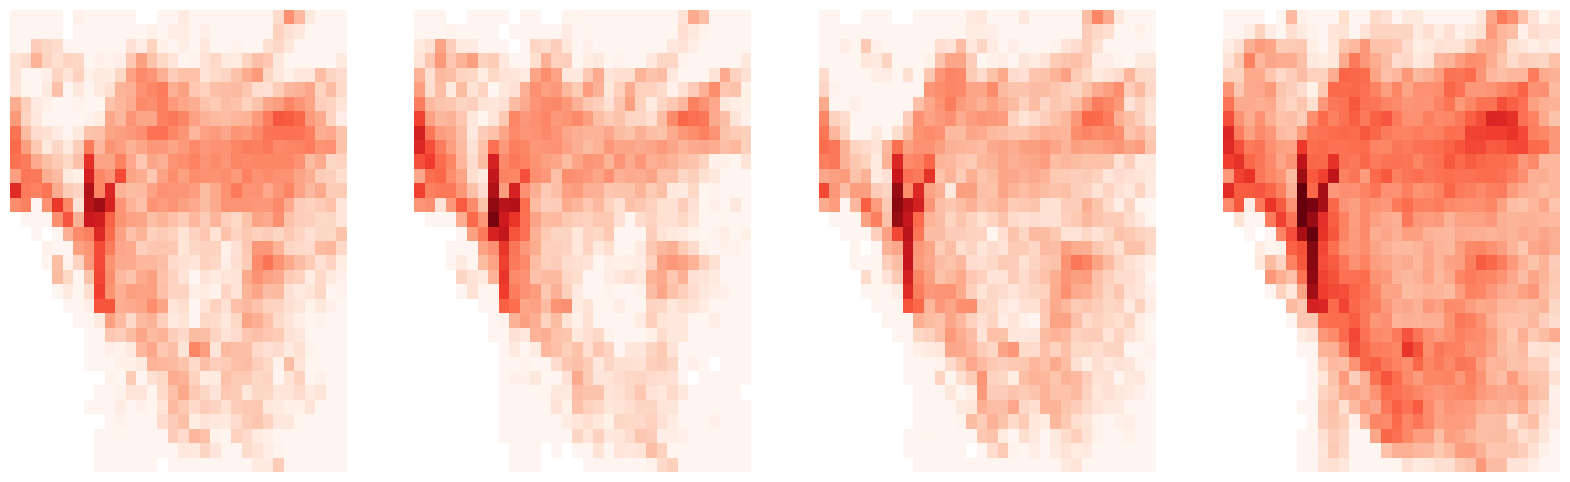

In [15]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


# Parameters for the random walk
grid_size = 32   # Size of the 2D grid
map_size = 256
reduction = map_size / grid_size
identity_grids = {}

for identity_key in identities:
    identity_grids[identity_key] = np.zeros((grid_size, grid_size))
    points = None
    for sample_key in samples.keys():
        if samples[sample_key][identity_key]["intersect"] is not None:
            if points is None:
                points = np.array(samples[sample_key][identity_key]["intersect"])
            else:
                points = np.concatenate((points, np.array(samples[sample_key][identity_key]["intersect"])), axis=0)
    points += 128
    for x, y in points:
        if x > 0 and y > 0:  # this is the default value when unsighted
            identity_grids[identity_key][int(x/reduction), int(y/reduction)] += 1

print(identity_grids.keys())
# Paper order is (A: Ebo, B: Zarafa, C:Kito, D: Jimyu) so we map
# dict_keys(['3'=Jimiyu, '1'=Zarafa, '2'=Ebo, '4'=Kito]) to ['2', '1', '4', '3']
render_order = ['2', '1', '4', '3']

fig, axes = plt.subplots(1, len(identity_grids.keys()), figsize=(20, 6))

for index, k in enumerate(render_order):
    ax = axes[index]
    grid = identity_grids[k]
    # for ax, grid in zip(axes, identity_grids.values()):
    sns.heatmap(
        grid, 
        cmap="Reds", 
        alpha=1.0, 
        cbar=False, 
        # mask=np.where(grid > 0.25, 0, 1), 
        ax=ax,
        robust=True,
        xticklabels=False,
        yticklabels=False,
        norm=mcolors.LogNorm(vmin=25,vmax=total_samples
        )
        # norm=mcolors.SymLogNorm(total_samples*.03, linscale=total_samples)        
    )

print(f"Found the following individuals: {[names[int(o) - 1] for o in identities]}")

for index, i in enumerate(identities):
    # axes[index].set_title(names[int(i) - 1])
    pass
plt.show()